In [12]:
import torch
from torch import nn


class GraphAttentionLayer(nn.Module):

    def __init__(self, in_features: int, out_features: int, n_heads: int,
                 is_concat: bool = True,
                 dropout: float = 0.6,
                 leaky_relu_negative_slope: float = 0.2):

        super().__init__()

        self.is_concat = is_concat
        self.n_heads = n_heads

        # Calculate the number of dimensions per head
        if is_concat:
            assert out_features % n_heads == 0
            # If we are concatenating the multiple heads
            self.n_hidden = out_features // n_heads
        else:
            # If we are averaging the multiple heads
            self.n_hidden = out_features

        # Linear layer for initial transformation;
        # i.e. to transform the node embeddings before self-attention
        self.linear = nn.Linear(in_features, self.n_hidden * n_heads, bias=False)
        # Linear layer to compute attention score $e_{ij}$
        self.attn = nn.Linear(self.n_hidden * 2, 1, bias=False)
        # The activation for attention score $e_{ij}$
        self.activation = nn.LeakyReLU(negative_slope=leaky_relu_negative_slope)
        # Softmax to compute attention $\alpha_{ij}$
        self.softmax = nn.Softmax(dim=1)
        # Dropout layer to be applied for attention
        self.dropout = nn.Dropout(dropout)

    def forward(self, h: torch.Tensor, adj_mat: torch.Tensor):

        # Number of nodes
        n_nodes = h.shape[0]
        # The initial transformation,
        # $$\overrightarrow{g^k_i} = \mathbf{W}^k \overrightarrow{h_i}$$
        # for each head.
        # We do single linear transformation and then split it up for each head.
        g = self.linear(h).view(n_nodes, self.n_heads, self.n_hidden)

        g_repeat = g.repeat(n_nodes, 1, 1)

        g_repeat_interleave = g.repeat_interleave(n_nodes, dim=0)

        g_concat = torch.cat([g_repeat_interleave, g_repeat], dim=-1)
        # Reshape so that `g_concat[i, j]` is $\overrightarrow{g_i} \Vert \overrightarrow{g_j}$
        g_concat = g_concat.view(n_nodes, n_nodes, self.n_heads, 2 * self.n_hidden)

        e = self.activation(self.attn(g_concat))
        # Remove the last dimension of size `1`
        e = e.squeeze(-1)

        # The adjacency matrix should have shape
        # `[n_nodes, n_nodes, n_heads]` or`[n_nodes, n_nodes, 1]`
        assert adj_mat.shape[0] == 1 or adj_mat.shape[0] == n_nodes
        assert adj_mat.shape[1] == 1 or adj_mat.shape[1] == n_nodes
        assert adj_mat.shape[2] == 1 or adj_mat.shape[2] == self.n_heads
        # Mask $e_{ij}$ based on adjacency matrix.
        # $e_{ij}$ is set to $- \infty$ if there is no edge from $i$ to $j$.
        e = e.masked_fill(adj_mat == 0, float('-inf'))

        a = self.softmax(e)

        # Apply dropout regularization
        a = self.dropout(a)

        attn_res = torch.einsum('ijh,jhf->ihf', a, g)

        # Concatenate the heads
        if self.is_concat:
            # $$\overrightarrow{h'_i} = \Bigg\Vert_{k=1}^{K} \overrightarrow{h'^k_i}$$
            return attn_res.reshape(n_nodes, self.n_heads * self.n_hidden)
        # Take the mean of the heads
        else:
            # $$\overrightarrow{h'_i} = \frac{1}{K} \sum_{k=1}^{K} \overrightarrow{h'^k_i}$$
            return attn_res.mean(dim=1)

In [3]:
from typing import Dict

import numpy as np
import torch
from torch import nn

from pathlib import Path

from download import download_file, extract_tar

torch.manual_seed(42)

class CoraDataset:
    def __init__(self, include_edges: bool = True):
        self.include_edges = include_edges

        # Download dataset
        self._download()

        # Read the paper ids, feature vectors, and labels
        content = np.genfromtxt('cora/cora/cora.content', dtype=np.dtype(str))

        # Load the citations, it's a list of pairs of integers.
        citations = np.genfromtxt('cora/cora/cora.cites', dtype=np.int32)

        features = torch.tensor(np.array(content[:, 1:-1], dtype=np.float32))
        self.features = features / features.sum(dim=1, keepdim=True)

        self.classes = {s: i for i, s in enumerate(set(content[:, -1]))}
        self.labels = torch.tensor([self.classes[i] for i in content[:, -1]], dtype=torch.long)

        paper_ids = np.array(content[:, 0], dtype=np.int32)
        ids_to_idx = {id_: i for i, id_ in enumerate(paper_ids)}

        self.adj_mat = torch.eye(len(self.labels), dtype=torch.bool)

        if self.include_edges:
            for e in citations:
                e1, e2 = ids_to_idx[e[0]], ids_to_idx[e[1]]
                self.adj_mat[e1][e2] = True
                self.adj_mat[e2][e1] = True

    def _download(self):
        data_dir = Path('cora')
        if not data_dir.exists():
            data_dir.mkdir(parents=True)

        tgz_file = data_dir / 'cora.tgz'
        content_file = data_dir / 'cora.content'

        if not content_file.exists():
            download_file('https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz', tgz_file)
            extract_tar(tgz_file, data_dir)


class GAT(nn.Module):
    def __init__(self, in_features: int, n_hidden: int, n_classes: int, n_heads: int, dropout: float):
        super().__init__()

        self.layer1 = GraphAttentionLayer(in_features, n_hidden, n_heads, is_concat=True, dropout=dropout)
        self.activation = nn.ELU()
        self.output = GraphAttentionLayer(n_hidden, n_classes, 1, is_concat=False, dropout=dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, adj_mat):
        x = self.dropout(x)
        x = self.layer1(x, adj_mat)
        x = self.activation(x)
        x = self.dropout(x)
        return self.output(x, adj_mat)


def accuracy(output: torch.Tensor, labels: torch.Tensor):
    """
    A simple function to calculate the accuracy
    """
    return output.argmax(dim=-1).eq(labels).sum().item() / len(labels)


class CoraConfig:
    def __init__(self):
        self.include_edges = True
        self.epochs = 1000
        self.model = None
        self.training_samples = 500
        self.in_features = None
        self.n_hidden = 64
        self.n_heads = 8
        self.n_classes = None
        self.dropout = 0.6
        self.dataset = CoraDataset(self.include_edges)
        self.loss_func = nn.CrossEntropyLoss()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.optimizer = None #torch.optim.Adam(self.model.parameters())

    def run(self):
        features = self.dataset.features.to(self.device)
        labels = self.dataset.labels.to(self.device)
        edges_adj = self.dataset.adj_mat.to(self.device)
        edges_adj = edges_adj.unsqueeze(-1)

        idx_rand = torch.randperm(len(labels))
        idx_train = idx_rand[:self.training_samples]
        idx_valid = idx_rand[self.training_samples:]

        for epoch in range(self.epochs):
            print(f'Epoch {epoch + 1}')
            self.model.train()
            self.optimizer.zero_grad()
            output = self.model(features, edges_adj)
            loss = self.loss_func(output[idx_train], labels[idx_train])
            loss.backward()
            self.optimizer.step()

            self.model.eval()
            with torch.no_grad():
                output = self.model(features, edges_adj)
                loss = self.loss_func(output[idx_valid], labels[idx_valid])


# Initialize the configuration
config = CoraConfig()


from torch.optim import Adam

# Define your GAT model
class GATModel(nn.Module):
    def __init__(self, in_features, n_hidden, n_classes, n_heads, dropout):
        super(GATModel, self).__init__()
        self.gat = GAT(in_features, n_hidden, n_classes, n_heads, dropout)

    def forward(self, x, adj_mat):
        return self.gat(x, adj_mat)

# Create your GAT model and optimizer
config.in_features = config.dataset.features.shape[1]
config.n_classes = len(config.dataset.classes)
config.model = GATModel(config.in_features, config.n_hidden, config.n_classes, config.n_heads, config.dropout)
config.optimizer = Adam(config.model.parameters(), lr=5e-3, weight_decay=5e-4)

PATH="weights"
config.model.load_state_dict(torch.load(PATH))
#config.model = torch.load(PATH)

<All keys matched successfully>

In [13]:
from torch.utils.data import DataLoader

PERM = [5, 0, 1, 6, 4, 2, 3]
PERM_m = np.argsort(PERM)

def evaluate(model, data, idx_test):
    features = data.features.to(config.device)
    labels = data.labels.to(config.device)
    edges_adj = data.adj_mat.to(config.device)
    edges_adj = edges_adj.unsqueeze(-1)
    model.eval()
    with torch.no_grad():
        output = config.model(features, edges_adj)
        #for some reasons, the labels are valid but get permuted in the output at each reloading of the model
        output = torch.FloatTensor([[v[PERM_m[i]] for i in range(7)] for v in output])
        loss = config.loss_func(output[idx_test], labels[idx_test])
        acc = accuracy(output[idx_test], labels[idx_test])
        #for i in range(7):
        #  print("class", i, ":", torch.sum(output.argmax(dim=-1).eq(i)).item())
    return output, loss.item(), acc

# Define evaluation set
labels = config.dataset.labels.to(config.device)
features = config.dataset.features.to(config.device)
idx_test = range(500, len(labels))
#idx_test = range(0,config.training_samples)

output, validation_loss, validation_accuracy = evaluate(config.model, config.dataset, idx_test)

print(f'Validation Loss: {validation_loss:.4f}')
print(f'Validation Accuracy: {validation_accuracy * 100:.4f}%')


Validation Loss: 0.9084
Validation Accuracy: 75.2717%


torch.Size([2708, 1433])
torch.Size([2708])
torch.Size([2708, 2708])


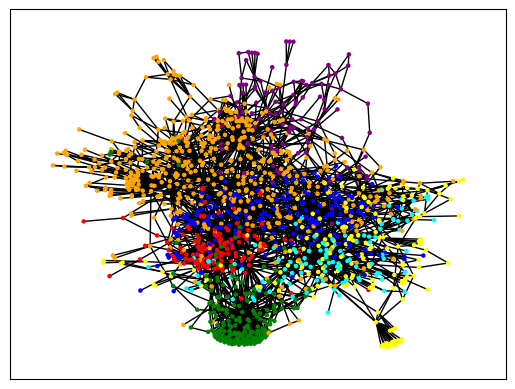

In [14]:
import matplotlib.pyplot as plt
import networkx as nx
import random

# Create a dictionary to store colors for each label
COLORS = ['blue', 'orange', 'yellow', 'red', 'purple', 'green', 'cyan', 'black']

def evaluate_individual(data, labels):
    features = data.features
    edges_adj = data.adj_mat
    # print all shapes
    print(features.shape)
    print(labels.shape)
    print(edges_adj.shape)
    #edges_adj = edges_adj.unsqueeze(-1)

    # Create a graph
    G = nx.from_numpy_array(edges_adj.numpy())

    # Assign labels and features to nodes
    for i, (feat, label) in enumerate(zip(features, labels)):
        G.nodes[i]['feature'] = feat
        G.nodes[i]['label'] = label

    v = 151

    radius = 6

    # extract the subgraph within the specified radius
    G = nx.ego_graph(G, v, radius=radius)

    # Identify and remove self-edges
    self_edges = list(nx.selfloop_edges(G))
    G.remove_edges_from(self_edges)

    # Draw the graph after keeping only the largest connected component
    pos_largest = nx.spring_layout(G, seed=42)
    node_colors = [COLORS[G.nodes[node]['label']] for node in G.nodes]
    #if node in train or valid
    #node_sizes = [30 if node in idx_test else 3 for node in G.nodes]
    node_sizes = 5
    nx.draw_networkx(G, pos_largest, with_labels=False, node_size=node_sizes, node_color=node_colors)
    #node_labels_largest = nx.get_node_attributes(G_largest, 'label')
    #nx.draw_networkx_labels(G_largest, pos_largest, labels=node_labels_largest)
    plt.show()

evaluate_individual(config.dataset, np.argmax(output, axis=-1))